In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MNIST loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [1]:
def poisson_encode(images, T):
    """
    Convert static images to spike trains using Poisson encoding.
    images: [B, 1, 28, 28] → returns [T, B, 784]
    """
    B = images.size(0)
    images = images.view(B, -1).to(images.device)  # Ensure images are on the correct device
    return (torch.rand(T, B, 784, device=images.device) < images.unsqueeze(0)).float()

In [4]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input >= 1.0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad = grad_output.clone()
        return grad * 1.0 / (1.0 + 10 * torch.abs(input - 1.0))**2


In [5]:
import numpy as np
class LIFLayer(nn.Module):
    def __init__(self, in_features, out_features, tau=2.0):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.spike_fn = SurrogateSpike.apply
        self.alpha = np.exp(-1.0 / tau)  # exponential decay factor

    def forward(self, input_spikes):  # input: [T, B, in_features]
        T, B, _ = input_spikes.shape
        v = torch.zeros(B, self.fc.out_features, device=input_spikes.device)
        spikes = []

        for t in range(T):
            I_t = self.fc(input_spikes[t])            # input current
            v = self.alpha * v + I_t                  # exponential decay update
            s = self.spike_fn(v)                      # spike if threshold crossed
            v = v * (1 - s)                           # reset voltage after spike
            spikes.append(s)

        return torch.stack(spikes)  # [T, B, out_features]



In [6]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = LIFLayer(784, 512)
        self.output = LIFLayer(512, 10)

    def forward(self, x):  # x: [T, B, 784]
        h = self.hidden(x)         # [T, B, 256]
        out = self.output(h)       # [T, B, 10]
        return out.sum(dim=0)      # [B, 10] summed over time


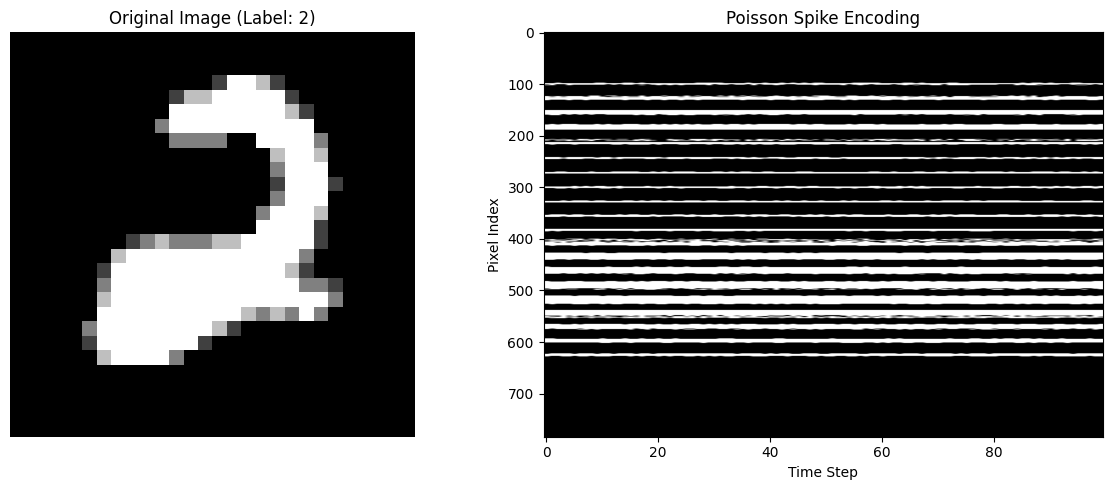

In [7]:
import matplotlib.pyplot as plt
def visualize_image_and_encoding(image, label, T=100):
    """
    Shows original MNIST image and its Poisson spike encoding.
    """
    image_flat = image.view(1, 1, 28, 28)  # [1, 1, 28, 28]
    spikes = (torch.rand(T, 1, 784) < image_flat.view(1, 1, -1)).float().squeeze(1)  # [T, 784]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title(f"Original Image (Label: {label})")
    axs[0].axis('off')

    # Spike raster plot
    axs[1].imshow(spikes.T, cmap='gray', aspect='auto')
    axs[1].set_title("Poisson Spike Encoding")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Pixel Index")

    plt.tight_layout()
    plt.show()
image_batch, label_batch = next(iter(train_loader))
sample_image = image_batch[0]
sample_label = label_batch[0].item()

visualize_image_and_encoding(sample_image, sample_label, T=100)

In [8]:
def train(model, dataloader, T=100, epochs=5):
    model = model.to(device)  # Move model to device
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            spike_input = poisson_encode(images, T).to(device)
            output = model(spike_input)  # [B, 10]
            loss = F.cross_entropy(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ✅ Print after each epoch
        avg_loss = total_loss / len(dataloader)
        loss_history = []
        loss_history.append(total_loss / len(dataloader))

        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")


In [9]:
def evaluate(model, dataloader, T=100):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            spike_input = poisson_encode(images, T).to(device)
            output = model(spike_input)
            preds = output.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")


In [25]:
model = SNN().to(device)
train(model, train_loader, T=100, epochs=5)
evaluate(model, test_loader, T=100)


Epoch 1/5, Avg Loss: 0.7874
Epoch 2/5, Avg Loss: 0.4051
Epoch 3/5, Avg Loss: 0.3204
Epoch 4/5, Avg Loss: 0.2703
Epoch 5/5, Avg Loss: 0.2619
Test Accuracy: 95.77%
